# Training and evaulation of the model

In [4]:
!pip install transformers
import torch
import json
import json
from pathlib import Path
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import pickle
from transformers import AdamW,BertForQuestionAnswering
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('./SQUAD2.0_DATA/tokenized/training_tokenized.pickle', 'rb') as output:
    training_batch = pickle.load(output)

with open('./SQUAD2.0_DATA/tokenized/validation_tokenized.pickle', 'rb') as output:
    validation_batch = pickle.load(output)

In [3]:
## Selecting BERT base uncased model
BERT_base = BertForQuestionAnswering.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [5]:
class data(torch.utils.data.Dataset):
  def __init__(self, batch):
    self.encodings = batch
  def __len__(self):
    return len(self.encodings.input_ids)
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

In [6]:
answer_start_positions, answer_end_positions = [], []
training_loss, validation_loss = [], []

In [7]:
training_data = data(training_batch)
training_dataLoader = DataLoader(training_data, batch_size=6, shuffle=True, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,)
# batch_sie = 8, 4, 10
validation_data = data(validation_batch)
validation_dataLoader = DataLoader(validation_data, batch_size=8, shuffle=True, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,)
# batch_sie = 8, 4, 10

In [8]:
for i in range(5): #5
    loss_i=0
    BERT_base.train()
    for _, batch in enumerate(training_dataLoader): 
        AdamW(BERT_base.parameters(), lr=3e-5).zero_grad()
        #  lr = 1e - 5
        #  lr = 2e - 5
        #  lr = 5e - 5
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']
        outputs=BERT_base(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        outputs[0].backward()
        AdamW(BERT_base.parameters(), lr=3e-5).step() # lr = 1e - 5, 2e - 5, lr = 5e - 5
        loss_i+=outputs[0].item()
    training_loss.append(loss_i/len(training_dataLoader))
    loss_i=0
    BERT_base.eval()
    for _, batch in enumerate(validation_dataLoader):
       with torch.no_grad():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']
        outputs=BERT_base(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss_i+=outputs[0].item()
    validation_loss.append(loss_i/len(validation_dataLoader))

torch.save(model,"./savedModels/finetuned_model.pkl")

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


: 

: 

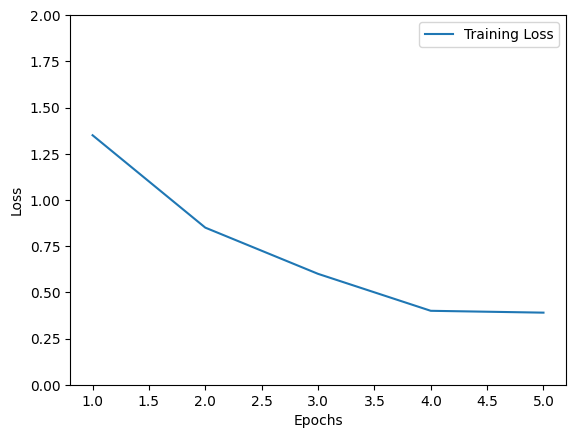

In [30]:
epochs=[1, 2, 3, 4, 5]
data_plot = pd.DataFrame({"Loss":training_loss, "Epochs":epochs})
sns.lineplot(x = "Epochs", y = "Loss", data=data_plot)
plt.ylim(0, 2)
plt.legend(labels=["Training Loss"])
plt.show()

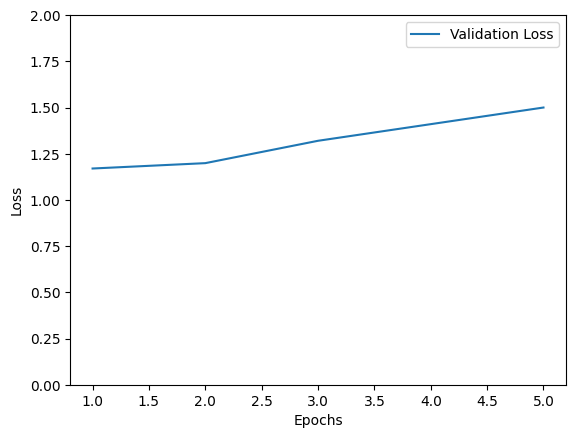

In [35]:
data_plot = pd.DataFrame({"Loss":validation_loss, "Epochs":epochs})
sns.lineplot(x = "Epochs", y = "Loss", data=data_plot)
plt.ylim(0, 2)
plt.legend(labels=["Validation Loss"])
plt.show()